In [1]:
%matplotlib inline

import os
import glob
import json
import time
import pickle
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception

# from keras.applications.xception import Xception

from keras.applications.imagenet_utils import preprocess_input

from keras.models import Model
from keras.layers import Input, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.utils import np_utils

from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from PIL import Image, ImageDraw
import bcolz

Using TensorFlow backend.


In [436]:
training_data_path = 'train'
annotations_path = 'weijie_kaggle/NCFM/datasets'
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
# classes = ['SHARK']
img_w = 448
img_h = 448
max_boxes = 4
batch_size = 32
nb_epoch = 100
early_stopping_patience = 5
debug = False
random_state = 42

In [437]:
# https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/forums/t/28150/unified-effort-to-relabel-the-training-set
relabels = {}
with open('relabels.csv') as f:
    for line in f:
        cols = line.split()
        src = "{}/{}/{}.jpg".format(training_data_path, cols[1], cols[0])
        class_label = cols[2]
        relabels[src] = class_label
        #dst = "{}/{}/{}.jpg".format(TRAIN_PATH, cols[2], cols[0])
print(relabels)

{'train/YFT/img_00739.jpg': 'revise', 'train/OTHER/img_06706.jpg': 'ALB', 'train/NoF/img_02044.jpg': 'ALB', 'train/OTHER/img_04948.jpg': 'ALB', 'train/NoF/img_00904.jpg': 'ALB', 'train/ALB/img_00568.jpg': 'NoF', 'train/ALB/img_02086.jpg': 'YFT', 'train/OTHER/img_05425.jpg': 'ALB', 'train/YFT/img_01007.jpg': 'revise', 'train/NoF/img_02232.jpg': 'SHARK', 'train/OTHER/img_06463.jpg': 'ALB', 'train/ALB/img_01363.jpg': 'OTHER', 'train/YFT/img_02364.jpg': 'revise', 'train/NoF/img_06478.jpg': 'revise', 'train/OTHER/img_06149.jpg': 'ALB', 'train/OTHER/img_06111.jpg': 'ALB', 'train/NoF/img_07100.jpg': 'ALB', 'train/NoF/img_04847.jpg': 'ALB', 'train/NoF/img_00028.jpg': 'ALB', 'train/OTHER/img_04057.jpg': 'ALB', 'train/NoF/img_03173.jpg': 'YFT', 'train/OTHER/img_02099.jpg': 'ALB', 'train/NoF/img_04052.jpg': 'revise', 'train/YFT/img_01087.jpg': 'revise', 'train/YFT/img_01610.jpg': 'revise', 'train/NoF/img_04590.jpg': 'ALB', 'train/NoF/img_02325.jpg': 'BET', 'train/NoF/img_00076.jpg': 'ALB', 'train

In [438]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

    
def load_array(fname):
    return bcolz.open(fname)[:]


def process_box_json(data, boxes):
    for item in data:
        filename = os.path.basename(item['filename'])
        cnt = 0
        for annotation in item['annotations']:
            x = annotation['x']
            y = annotation['y']
            w = annotation['width']
            h = annotation['height']
            c = annotation['class']
            if not c in boxes:
                boxes[c] = {}
            if not filename in boxes[c]:
                boxes[c][filename] = []
            boxes[c][filename].extend([x, y, x+w, y+h])


def read_boxes():
    boxes = {}
    for c in classes:
        json_file = os.path.join(annotations_path, c + '.json') 
        if not os.path.isfile(json_file):
            continue
        with open(json_file) as f:
            data = json.load(f)
            process_box_json(data, boxes)
    return boxes


def save_img(orig_img, bboxes, fname):
    img = Image.new('RGB', (orig_img.width, orig_img.height), (255, 255, 255))
    img.paste(orig_img)
    draw = ImageDraw.Draw(img)
    for i in range(0, len(bboxes), 4):
        bbox = (bboxes[i + 0], bboxes[i + 1], bboxes[i + 2], bboxes[i + 3])
        draw.line((bbox[0], bbox[1], bbox[2], bbox[1]), fill=(255, 0, 0))
        draw.line((bbox[2], bbox[1], bbox[2], bbox[3]), fill=(255, 0, 0))
        draw.line((bbox[2], bbox[3], bbox[0], bbox[3]), fill=(255, 0, 0))
        draw.line((bbox[0], bbox[3], bbox[0], bbox[1]), fill=(255, 0, 0))
    del draw
    img.save(open(fname, 'wb'))

In [439]:
def read_training_data(path):
    # {'ALB': {'image_path.jpg': [(x1, y1, x2, y2), ...], }}
    boxes = read_boxes()
    X_train = []
    y_train = []
    y_train_box = []

    t0 = time.time()
    print('Reading training data...')

    for class_folder in classes:
        image_paths = glob.glob(os.path.join(path, class_folder, '*.jpg'))
        class_index = classes.index(class_folder)
        print('Loading class: {}'.format(class_folder))

        for image_path in image_paths:
            # print('Reading: ', image_path)
            image_name = os.path.basename(image_path)

            img = image.load_img(image_path)
            x_scale = float(img_w) / float(img.width)
            y_scale = float(img_h) / float(img.height)
            # print('Scale factors (x, y): ', x_scale, y_scale)
            img = img.resize((img_w, img_h))

            box = [0, 0, 0, 0]
            if class_folder in boxes:
                if image_name in boxes[class_folder]:
                    image_boxes = boxes[class_folder][image_name]
                    image_boxes.extend(max_boxes * [0, 0, 0, 0])
                    box = [0, 0, 0, 0]
                    
                    # scale bounding boxes
                    for i in range(0, len(image_boxes), 4):
                        if (image_boxes[i + 2] * image_boxes[i + 3]) > (box[2] * box[3]):
                            box[0] = image_boxes[i]
                            box[1] = image_boxes[i + 1]
                            box[2] = image_boxes[i + 2]
                            box[3] = image_boxes[i + 3]
                    
                    box[0] = x_scale * image_boxes[0]
                    box[1] = y_scale * image_boxes[1]
                    box[2] = x_scale * image_boxes[2]
                    box[3] = y_scale * image_boxes[3]
            
            add = True
            img_class = class_index
            if image_path in relabels:
                if relabels[image_path] == 'revise':
                    add = False
                else:
                    print('revised: ', image_path, relabels[image_path])
                    img_class = classes.index(relabels[image_path])
            
            if add:
                img = image.img_to_array(img)
                X_train.append(img)
                y_train.append(img_class)
                y_train_box.append(box)
            else:
                print('omitted: ', image_path)

    X_train = np.array(X_train)
    preprocess_input(X_train)
    y_train = np.array(y_train, dtype=np.uint8)
    y_train = np_utils.to_categorical(y_train, 8)
    y_train_box = np.array(y_train_box, dtype=np.float32)

    t1 = time.time()
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2)))
    print('Training data shape:', X_train.shape)
    return X_train, y_train, y_train_box

In [440]:
def run_test(model, test_path):
    image_paths = glob.glob(os.path.join(test_path, '*.jpg'))
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(img_w, img_h))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        model_prediction = model.predict(x)
        print(model_prediction[0])
        save_img(img, model_prediction[0],
                 os.path.join(os.path.dirname(image_path),
                              'predicted_' + os.path.basename(image_path)))

In [441]:
# load_and_test_model('weights.84-346.48.hdf5', 'test_stg1')
if os.path.isfile('/home/abanki/fish/train.bcolz'):
    print('Loading training data..')
    X = load_array('train.bcolz')
    y = load_array('y.bcolz')
    y_box = load_array('y_box.bcolz')
    print('Done')
else:
    X, y, y_box = read_training_data(training_data_path)
    print('Saving training data..')
    save_array('train.bcolz', X)
    save_array('y.bcolz', y)
    save_array('y_box.bcolz', y_box)
    print('Done')

Reading training data...
Loading class: ALB
revised:  train/ALB/img_02086.jpg YFT
revised:  train/ALB/img_00248.jpg OTHER
revised:  train/ALB/img_01363.jpg OTHER
revised:  train/ALB/img_00568.jpg NoF
Loading class: BET
Loading class: DOL
omitted:  train/DOL/img_07212.jpg
Loading class: LAG
Loading class: NoF
omitted:  train/NoF/img_01989.jpg
omitted:  train/NoF/img_03386.jpg
revised:  train/NoF/img_06031.jpg ALB
revised:  train/NoF/img_06675.jpg ALB
revised:  train/NoF/img_07724.jpg YFT
revised:  train/NoF/img_04847.jpg ALB
revised:  train/NoF/img_02325.jpg BET
revised:  train/NoF/img_04590.jpg ALB
revised:  train/NoF/img_00076.jpg ALB
revised:  train/NoF/img_04615.jpg ALB
revised:  train/NoF/img_00904.jpg ALB
revised:  train/NoF/img_00028.jpg ALB
revised:  train/NoF/img_02621.jpg ALB
revised:  train/NoF/img_06266.jpg YFT
revised:  train/NoF/img_02302.jpg ALB
revised:  train/NoF/img_03949.jpg BET
omitted:  train/NoF/img_06478.jpg
revised:  train/NoF/img_02044.jpg ALB
revised:  train/No

In [442]:
def create_vgg(w, h):
    model = VGG16(include_top=False, weights='imagenet',
                  input_tensor=Input(shape=(h, w, 3)))

    for layer in model.layers:
        layer.trainable = False

    return model

In [8]:
def create_xception(w, h):
    model = Xception(include_top=False, weights='imagenet', input_tensor=Input(shape=(h, w, 3)))
    
    for layer in model.layers:
        layer.trainable = False
    return model

In [443]:
from keras import backend as K
K.clear_session()

vgg = create_vgg(img_w, img_h)
X_feat = []
bsize = 16
for batch in range(0, len(X), bsize):
    X_feat.extend(vgg.predict(X[batch:batch+bsize]))
X_feat = np.array(X_feat)
save_array('train_vgg_feat.bcolz', X_feat)

In [444]:
# vgg.summary()
print(np.shape(X_feat))


(3759, 14, 14, 512)


In [445]:
# VGG features
vgg = create_vgg(img_w, img_h)
X_feat = load_array('train_vgg_feat.bcolz')
y = load_array('y.bcolz')
y_box = load_array('y_box.bcolz')
print(np.shape(X_feat))
print(np.shape(y))
print(np.shape(y_box))

(3759, 14, 14, 512)
(3759, 8)
(3759, 4)


In [446]:
y_box_tl = []
y_box_br = []
for item in y_box:
    y_box_tl.append([item[0], item[1]])
    y_box_br.append([item[2], item[3]])
y_box_tl = np.array(y_box_tl)
y_box_br = np.array(y_box_br)

print(np.shape(y_box_tl))
print(np.shape(y_box_br))

(3759, 2)
(3759, 2)


In [459]:
print('Features shape: ', np.shape(X_feat))
print('Classes shape: ', np.shape(y))
print('Boxes shape: ', np.shape(y_box))
time_str = str(datetime.datetime.now()).replace(' ', '_')

callbacks = [
        # CSVLogger('bbox_regression_' + time_str + '.csv', separator=',', append=False),
        # ModelCheckpoint('weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        #                 save_best_only=True,
        #                 monitor='val_loss', verbose=1),
        EarlyStopping(monitor='val_loss', patience=early_stopping_patience),
]

ss = StratifiedShuffleSplit(n_splits=2, test_size=0.3)
train_idx, test_idx = next(ss.split(X_feat, y.argmax(1)))

# max_factor = len(np.where(y[train_idx].argmax(1) == 0)[0])
'''
class_w = {0: 1.,
           1: 3.,
           2: 5.,
           3: 7.,
           4: 1.5,
           5: 3.,
           6: 3.,
           7: 1.}
'''

class_w = {}

def class_stat(y):
    max_factor = max([len(np.where(y.argmax(1) == i)[0]) for i in range(len(classes))])
    
    for i in range(len(classes)):
        l = len(np.where(y.argmax(1) == i)[0])
        f = max_factor / l
        class_w[i] = f
        wf = f / class_w[i]
        percent = l / (len(y) / 100.)
        print('class: {}\t %: {:.2f}\t n: {} [{:.2f} -> {:.2f}]'.format(classes[i], percent, l, f, wf))

print('Train')
class_stat(y[train_idx])
print('Test')
class_stat(y[test_idx])


Features shape:  (3759, 14, 14, 512)
Classes shape:  (3759, 8)
Boxes shape:  (3759, 4)
Train
class: ALB	 %: 46.41	 n: 1221 [1.00 -> 1.00]
class: BET	 %: 5.36	 n: 141 [8.66 -> 1.00]
class: DOL	 %: 3.08	 n: 81 [15.07 -> 1.00]
class: LAG	 %: 1.82	 n: 48 [25.44 -> 1.00]
class: NoF	 %: 11.63	 n: 306 [3.99 -> 1.00]
class: OTHER	 %: 7.60	 n: 200 [6.11 -> 1.00]
class: SHARK	 %: 4.68	 n: 123 [9.93 -> 1.00]
class: YFT	 %: 19.42	 n: 511 [2.39 -> 1.00]
Test
class: ALB	 %: 46.45	 n: 524 [1.00 -> 1.00]
class: BET	 %: 5.41	 n: 61 [8.59 -> 1.00]
class: DOL	 %: 3.10	 n: 35 [14.97 -> 1.00]
class: LAG	 %: 1.77	 n: 20 [26.20 -> 1.00]
class: NoF	 %: 11.61	 n: 131 [4.00 -> 1.00]
class: OTHER	 %: 7.62	 n: 86 [6.09 -> 1.00]
class: SHARK	 %: 4.61	 n: 52 [10.08 -> 1.00]
class: YFT	 %: 19.41	 n: 219 [2.39 -> 1.00]


In [460]:
from keras.optimizers import Adam, Nadam, Adamax, SGD

def create_model(input_shape, dropout = 0.6, lr=0.001, decay=1e-6):
    inp = Input(shape=input_shape)
    
    # x = GlobalAveragePooling2D()(inp)
    # x = MaxPooling2D()(inp)
    x = BatchNormalization()(inp)
    x = Flatten()(x)
    
    x = Dense(1024)(x)
    x = PReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    
    x1 = Dense(128)(x) #, activation='relu')(x)
    x1 = PReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout)(x1)
    
    x1 = Dense(128)(x) #, activation='relu')(x)
    x1 = PReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(dropout)(x1)
    
    x2 = Dense(1024)(x) #, activation='relu')(x)
    x2 = PReLU()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout)(x2)
    
    x2 = Dense(1024)(x) #, activation='relu')(x)
    x2 = PReLU()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(dropout)(x2)
    
    bbox_predictions1 = Dense(2, activation='linear', name='bbox_tl')(x1)
    bbox_predictions2 = Dense(2, activation='linear', name='bbox_br')(x1)
    fish_predictions = Dense(8, activation='softmax', name='class')(x2)
    
    '''
    eddigi legjobb: 640x480, maxpool, bn, flatten
    x1: 256,prelu,bn,do; 256,prelu,bn,do,bp1,bp2
    x2: 256,prelu,bn,do; 256,prelu,bn,do,fp
    do: 0.5
    lr=0.05, decay=1e-6
    epoch: 10
    
    other best: save_model(model, 6, 'val_class_acc_9078')
    epoch: 40
    dropout=0.7, lr=0.04, decay=1e-6
    '''
    
    model = Model(input=inp, output=[bbox_predictions1, bbox_predictions2, fish_predictions]) 
    model.compile(optimizer=SGD(lr=lr, decay=decay, momentum=0.9, nesterov=True),
                  loss=['mse', 'mse', 'categorical_crossentropy'],
                  loss_weights=[0.0001, 0.0001, 1.0],
                  metrics=['accuracy', 'fmeasure'])
    return model

In [461]:
model = create_model(np.shape(X_feat)[1:], dropout=0.7, lr=0.04, decay=1e-6)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 14, 14, 512)   0                                            
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorm (None, 14, 14, 512)   2048        input_5[0][0]                    
____________________________________________________________________________________________________
flatten_3 (Flatten)              (None, 100352)        0           batchnormalization_13[0][0]      
____________________________________________________________________________________________________
dense_11 (Dense)                 (None, 1024)          102761472   flatten_3[0][0]                  
___________________________________________________________________________________________

In [462]:
history = model.fit(X_feat[train_idx],
                    [y_box_tl[train_idx], y_box_br[train_idx], y[train_idx]],
                    batch_size=batch_size,
                    nb_epoch=40,
                    validation_data=(X_feat[test_idx], [y_box_tl[test_idx], y_box_br[test_idx], y[test_idx]]),
                    verbose=1, class_weight=class_w)
                    # callbacks=callbacks,
                    # verbose=1)

Train on 2631 samples, validate on 1128 samples
Epoch 1/40
2631/2631 [==============================] - 8s - loss: 15.3108 - bbox_tl_loss: 31192.8796 - bbox_br_loss: 63983.8369 - class_loss: 5.7931 - bbox_tl_acc: 0.6450 - bbox_tl_fmeasure: 0.7047 - bbox_br_acc: 0.6431 - bbox_br_fmeasure: 0.7244 - class_acc: 0.5070 - class_fmeasure: 0.5059 - val_loss: 14.9981 - val_bbox_tl_loss: 27723.4352 - val_bbox_br_loss: 59275.6393 - val_class_loss: 6.2982 - val_bbox_tl_acc: 0.7748 - val_bbox_tl_fmeasure: 0.8278 - val_bbox_br_acc: 0.7456 - val_bbox_br_fmeasure: 0.7948 - val_class_acc: 0.5895 - val_class_fmeasure: 0.5895

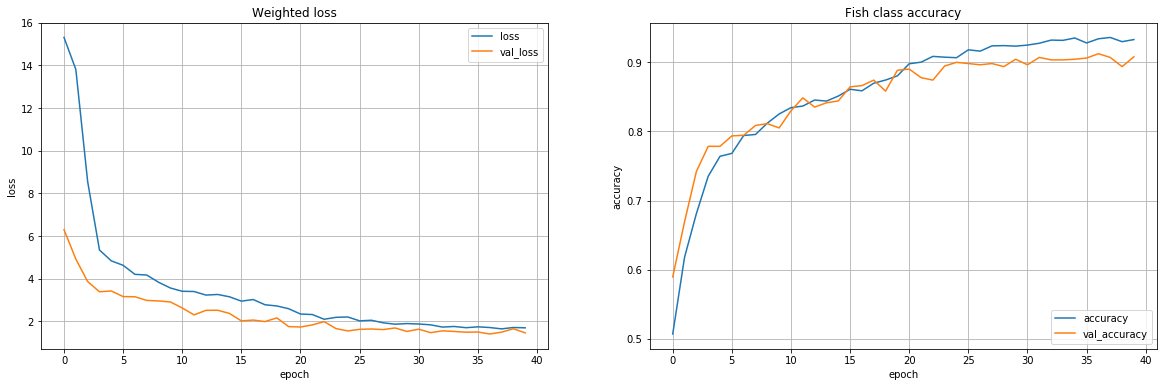

In [463]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.title('Weighted loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_class_loss'], label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.subplot(122)
plt.title('Fish class accuracy')
plt.plot(history.history['class_acc'], label='accuracy')
plt.plot(history.history['val_class_acc'], label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.show()

In [482]:
def save_model(model, index, cross=''):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    json_name = 'architecture' + str(index) + cross + '.json'
    weight_name = 'model_weights' + str(index) + cross + '.h5'
    open(os.path.join('cache', json_name), 'w').write(json_string)
    model.save_weights(os.path.join('cache', weight_name), overwrite=True)


save_model(model, 6, 'val_class_acc_9078')
# model.save_weights('curr_good.h5')


In [65]:
# pseudo labeling + dark knowledge
X_val_feat = []
bsize = 8
for batch in range(0, len(X[test_idx]), bsize):
    X_val_feat.extend(vgg.predict(X[test_idx][batch:batch+bsize]))

X_val_feat = np.array(X_val_feat)

y_val = model.predict(X_val_feat)

X_pseudo = np.concatenate([X_feat[train_idx], X_val_feat])
y_box_pseudo = np.concatenate([y_box[train_idx], y_val[0]])
y_pseudo = np.concatenate([y[train_idx], y_val[1]])

print(np.shape(X_pseudo))
print(np.shape(y_box_pseudo))
print(np.shape(y_pseudo))

(3759, 15, 20, 512)
(3759, 4)
(3759, 8)


In [ ]:
pseudo_model = create_model(np.shape(X_pseudo)[1:])
pseudo_model.load_weights('curr.h5')
# model.summary()
history = pseudo_model.fit(X_pseudo,
                    [y_box_pseudo, y_pseudo],
                    batch_size=batch_size,
                    nb_epoch=50,
                    validation_data=(X_feat[test_idx], [y_box[test_idx], y[test_idx]]),
                    callbacks=callbacks,
                    verbose=1)

Train on 3759 samples, validate on 752 samples
Epoch 1/50
3759/3759 [==============================] - 11s - loss: 3.6235 - bbox_loss: 1415.2085 - class_loss: 0.0854 - bbox_acc: 0.8300 - class_acc: 0.9800 - val_loss: 5.0516 - val_bbox_loss: 1870.4983 - val_class_loss: 0.3753 - val_bbox_acc: 0.8404 - val_class_acc: 0.9707

In [70]:
# show_predicted_box(model, 2)
pred = pseudo_model.predict(X_feat[test_idx])

In [82]:
pseudo_model.save_weights('pseudo1')

In [23]:
import copy

def create_rect_xywh(box, color='red'):
    return plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                         color=color, fill=False, linewidth=2)

def show_box(idx):
    bb = X_valid[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))

def to_plot(img):
    return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    x = copy.copy(img)
    x = x + max(-np.min(x), 0)
    x_max = np.max(x)
    if x_max != 0:
        x /= x_max
    x *= 255
    plt.imshow(np.array(x, dtype=np.uint8))

def show_predicted_box(model, i):
    box = y_box[test_idx][i]
    prediction = model.predict(np.expand_dims(X_feat[test_idx][i], axis=0))
    box_pred = prediction[0][0]
    plt.figure(figsize=(4.5, 6))
    plot(X[test_idx][i])
    ax = plt.gca()
    
    if box_pred[2] > 0 and box_pred[3] > 0:
        ax.add_patch(create_rect_xywh(box_pred, 'yellow'))

    if box[2] > 0 and box[3] > 0:
        ax.add_patch(create_rect_xywh(box, 'red'))

In [24]:
diff = np.array(pred[0], dtype=np.float32) - y_box[test_idx]
mse = np.empty((len(pred[0]),))
for i in range(len(pred[0])):
    mse[i] = np.dot(diff[i], diff[i])
sorted_mse = np.argsort(mse)

def plot_fish_and_boxes(idx):
    # idx = sorted_mse[idx]
    show_predicted_box(pseudo_model, idx)
    print('class: ', classes[np.argmax(pred[1][idx])])
    print('mse: ', mse[idx])
    print('orig boxes: ', np.array(y_box[test_idx][idx], dtype=np.int32))
    print('pred boxes: ', np.array(pred[0][idx], dtype=np.int32))
idx = 150
print(sorted_mse[idx])
plot_fish_and_boxes(sorted_mse[idx])

NameError: name 'pred' is not defined

In [477]:
def load_test_data(path):
    X_test = []
    Id_test = []
    t0 = time.time()

    image_paths = glob.glob(os.path.join(path, '*.jpg'))
    for image_path in image_paths:
        img = image.load_img(image_path, target_size=(img_h, img_w))
        x = image.img_to_array(img)
        X_test.append(x)
        Id_test.append(os.path.basename(image_path))

    X_test = np.array(X_test)
    X_test = preprocess_input(X_test)
    t1 = time.time()
    print('Test data shape:', X_test.shape)
    print('Reading finished: {} seconds'.format(round(t1 - t0, 2)))
    return X_test, Id_test


def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()


def create_submission(ids, predictions, info):
    result = pd.DataFrame(predictions, columns=classes)
    result.loc[:, 'image'] = pd.Series(ids, index=result.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    result.to_csv(sub_file, index=False)

    
def run_cross_validation_process_test(path, info_string, models):
    test_predictions = []
    X_test, id_test = load_test_data(path)

    for i in range(len(models)):
        Test_val_feat = []
        bsize = 8
        for batch in range(0, len(X_test), bsize):
            Test_val_feat.extend(vgg.predict(X_test[batch:batch+bsize]))
        
        Test_val_feat = np.array(Test_val_feat)
        print(np.shape(Test_val_feat))
        print('Testing model # {}/{}'.format(i + 1, len(models)))
        model_prediction = models[i].predict(Test_val_feat,
                                             batch_size=batch_size,
                                             verbose=1)
        print(np.shape(np.array(model_prediction[2])))
        test_predictions.append(model_prediction[2])
    print(test_predictions)
    y_pred = merge_several_folds_mean(test_predictions, len(models))
    create_submission(id_test,
                      y_pred,
                      'loss_' + info_string + '_folds_' + str(len(models)))

In [452]:
X_test, Id_test = load_test_data('test_stg1')
Id_test = np.array(Id_test)
save_array('test.bcolz', X_test)
save_array('test_ids.bcolz', Id_test)

X_test_feat = []
bsize = 16
for batch in range(0, len(X_test), bsize):
    X_test_feat.extend(vgg.predict(X_test[batch:batch+bsize]))

X_test_feat = np.array(X_test_feat)
save_array('test_feat.bcolz', X_test_feat)

Test data shape: (1000, 448, 448, 3)
Reading finished: 8.19 seconds


In [453]:
X_test_feat = load_array('test_feat.bcolz')
Id_test = load_array('test_ids.bcolz')
print(np.shape(X_test_feat))
print(np.shape(Id_test))

(1000, 14, 14, 512)
(1000,)


In [478]:
run_cross_validation_process_test('test_stg1', 'split_model', [model])

Test data shape: (1000, 448, 448, 3)
Reading finished: 17.81 seconds
(1000, 14, 14, 512)
Testing model # 1/1
1000/1000 [==============================] - 0s     

id:  img_03715.jpg
class:  ALB
prediction 
[ 212.22662354  156.16642761]
[ 317.84048462  268.02865601]


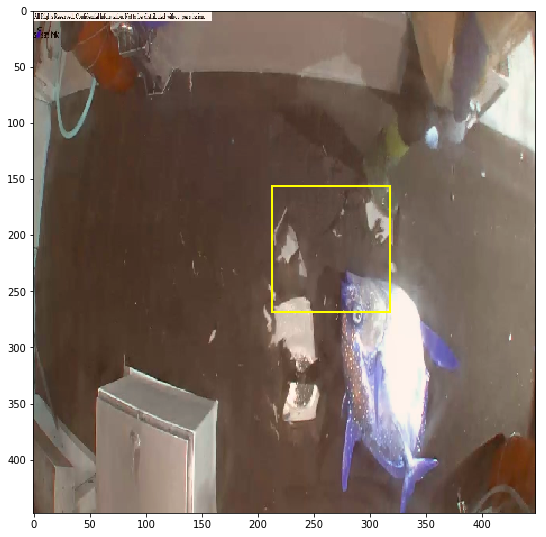

In [475]:
sorted_ids = np.argsort(Id_test)
def show_test(model, i):
    prediction = model.predict(np.expand_dims(X_test_feat[i], axis=0))
    box_pred_tl = prediction[0][0]
    box_pred_br = prediction[1][0]
    plt.figure(figsize=(9, 12))
    plot(X_test[i])
    ax = plt.gca()
    print('id: ', Id_test[i])
    print('class: ', classes[np.argmax(prediction[2][0])])
    print('prediction ')
    box_pred = []
    box_pred.extend(box_pred_tl)
    print(box_pred_tl)
    print(box_pred_br)
    box_pred.extend(box_pred_br)
    if box_pred[2] > 0 and box_pred[3] > 0:
        ax.add_patch(create_rect_xywh(box_pred, 'yellow'))

show_test(model, sorted_ids[451])

In [27]:
e = [model.evaluate(X[test_idx], [y_box[test_idx], y[test_idx]]) for i in range(3)]


756/756 [==============================] - 4s     

In [34]:
d = {}
for i in range(3):
    d.update(dict(zip(model.metrics_names, e[i])))
d

{'loss': [0.61240141795425818,
  355.9236902307581,
  0.25647771704779376,
  0.70105820168893807,
  0.96296296264759451]}